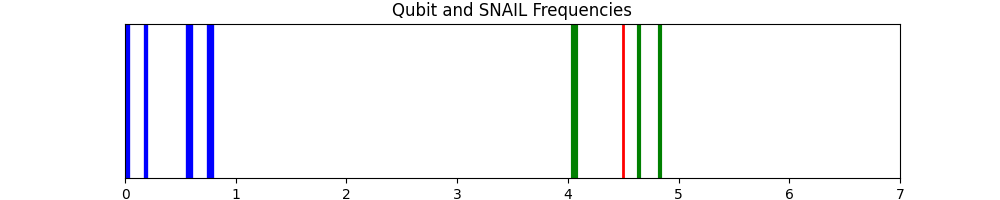

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Layout
import numpy as np

%matplotlib widget

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Number of qubits can be adjusted here
num_qubits = 4

# Create sliders for qubits and SNAIL
sliders = {
    f"qubit_{i}": FloatSlider(
        value=np.random.uniform(3, 6),
        min=0,
        max=6,
        description=f"Qubit {i}",
        # orientation="vertical",
        continuous_update=False,
        step=0.01,
    )
    for i in range(num_qubits)
}
sliders["snail"] = FloatSlider(
    value=4.5,
    min=3,
    max=7,
    description="SNAIL",
    # orientation="vertical",
    continuous_update=False,
    step=0.01,
)


# initialize the dictionary
initial_frequencies = np.linspace(3, 7, num_qubits + 1)  # +1 for SNAIL
frequency_dict = {}
for qubit in range(num_qubits):
    frequency_dict[f"qubit_{qubit}"] = ax.axvline(
        initial_frequencies[qubit], color="green", linestyle="-", linewidth=3
    )
frequency_dict["snail"] = ax.axvline(
    initial_frequencies[-1], color="red", linestyle="-", linewidth=2
)

# add frequency pairs to the dictionary (sum and difference)
# use frozenset() to ensure that the order of the keys doesn't matter
for i, mode1 in enumerate(initial_frequencies):
    for j, mode2 in enumerate(initial_frequencies):
        if i == j:
            continue
        key1 = f"qubit_{i}"
        key2 = f"qubit_{j}"
        if i == len(initial_frequencies) - 1:
            key1 = "snail"
        if j == len(initial_frequencies) - 1:
            key2 = "snail"

        freq1 = initial_frequencies[i]
        freq2 = initial_frequencies[j]

        sum_freq = freq1 + freq2
        diff_freq = abs(freq1 - freq2)
        sum_key = f"sum_{key1}_{key2}"
        diff_key = f"diff_{key1}_{key2}"
        # frequency_dict[sum_key] = sum_freq
        # frequency_dict[diff_key] = diff_freq

        alpha = 1
        if "snail" in sum_key:
            color = "red"
            # transparenet
            alpha = 0
        else:
            color = "blue"

        frequency_dict[sum_key] = ax.axvline(
            sum_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )
        frequency_dict[diff_key] = ax.axvline(
            diff_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )

# Initialize plot properties
ax.set_xlim(0, 7)
ax.get_yaxis().set_visible(False)
plt.title("Qubit and SNAIL Frequencies")


# Function to update the plot
def update_plot(**mode_frequencies):
    # Update the frequency lines
    for mode, freq in mode_frequencies.items():
        frequency_dict[mode].set_xdata([freq, freq])

    # update the pairs
    for key1, freq1 in mode_frequencies.items():
        for key2, freq2 in mode_frequencies.items():
            if key1 == key2:
                continue
            sum_freq = freq1 + freq2
            diff_freq = abs(freq1 - freq2)
            sum_key = f"sum_{key1}_{key2}"
            diff_key = f"diff_{key1}_{key2}"
            frequency_dict[sum_key].set_xdata([sum_freq, sum_freq])
            frequency_dict[diff_key].set_xdata([diff_freq, diff_freq])

    # Redraw the figure to update the lines
    fig.canvas.draw_idle()


# Layout adjustments for better UI
slider_layout = VBox(list(sliders.values()), layout=Layout(width="400"))
plot_layout = interactive_output(update_plot, sliders)

# Display the interactive widgets alongside the plot
display(HBox([slider_layout, plot_layout]))

In [18]:
import numpy as np
from itertools import combinations

# Initial parameters
min_freq = 4.0  # Minimum allowable frequency
max_freq = 6.0  # Maximum allowable frequency
initial_frequencies = [min_freq, max_freq]  # Starting frequencies for N=2 qubits
step_size = 1 / 1200  # Step size for iterating frequencies


# Function to calculate separations and check for valid configurations
def calculate_separation_metrics(frequencies):
    pairs = combinations(frequencies, 2)
    separations = [abs(a - b) for a, b in pairs]
    min_separation = min(separations, default=0)
    avg_separation = sum(separations) / len(separations) if separations else 0
    return min_separation, avg_separation


# Function to optimize frequencies for an additional qubit
def optimize_additional_qubit(fixed_frequencies):
    best_solutions = []
    max_min_separation = 0
    max_avg_separation = 0

    for freq in np.arange(min_freq, max_freq + step_size, step_size):
        all_freqs = fixed_frequencies + [freq]
        interaction_freqs = all_freqs[:]

        # Calculate sum and difference frequencies for qubit pairs
        for q1, q2 in combinations(all_freqs, 2):
            interaction_freqs.append(q1 + q2)
            interaction_freqs.append(abs(q1 - q2))

        min_sep, avg_sep = calculate_separation_metrics(interaction_freqs)
        if min_sep > max_min_separation or (
            min_sep == max_min_separation and avg_sep > max_avg_separation
        ):
            best_solutions = [(all_freqs, min_sep, avg_sep)]
            max_min_separation, max_avg_separation = min_sep, avg_sep
        elif min_sep == max_min_separation and avg_sep == max_avg_separation:
            best_solutions.append((all_freqs, min_sep, avg_sep))

    return best_solutions


def optimize_snail(fixed_frequencies):
    best_snail_freq = None
    best_min_separation = 0
    best_avg_separation = 0

    # Pre-calculate qubit-qubit interaction frequencies to ensure they don't overlap with qubit-SNAIL
    qubit_qubit_interactions = set()
    for q1, q2 in combinations(fixed_frequencies, 2):
        qubit_qubit_interactions.add(q1 + q2)
        qubit_qubit_interactions.add(abs(q1 - q2))

    for snail_freq in np.arange(min_freq, max_freq + step_size, step_size):
        # Calculate interactions including the SNAIL, but only check for clashes against qubit-qubit interactions
        qubit_snail_interactions = set()
        for qubit_freq in fixed_frequencies:
            qubit_snail_interactions.add(qubit_freq + snail_freq)
            qubit_snail_interactions.add(abs(qubit_freq - snail_freq))

        # Check for overlap with qubit-qubit interactions but allow qubit-SNAIL overlaps
        if (
            not qubit_snail_interactions & qubit_qubit_interactions
        ):  # No overlap with qubit-qubit interactions
            all_interactions = qubit_qubit_interactions.union(qubit_snail_interactions)
            min_sep, avg_sep = calculate_separation_metrics(all_interactions)
            if min_sep > best_min_separation or (
                min_sep == best_min_separation and avg_sep > best_avg_separation
            ):
                best_snail_freq = snail_freq
                best_min_separation, best_avg_separation = min_sep, avg_sep

    return best_snail_freq, best_min_separation, best_avg_separation


# Greedy optimization for each additional qubit
fixed_frequencies = initial_frequencies
N = 6  # Target number of qubits
# print qubit 0 and 1
print(f"Qubits 1: Frequencies={fixed_frequencies[-2]:.4f}")
print(f"Qubits 2: Frequencies={fixed_frequencies[-1]:.4f}")
for n in range(3, N + 1):
    best_solutions = optimize_additional_qubit(fixed_frequencies)
    if best_solutions:
        # Choose one of the best solutions
        fixed_frequencies, min_sep, avg_sep = (
            best_solutions[0][0],
            best_solutions[0][1],
            best_solutions[0][2],
        )
        print(
            f"Qubits {n}: Frequencies={fixed_frequencies[-1]:.4f}, Min Sep={min_sep:.4f}, Avg Sep={avg_sep:.4f}"
        )
        if len(best_solutions) > 1:
            print("Degenerate solutions found.")
    else:
        print(f"No solution found for {n} qubits.")

snail_freq, min_sep, avg_sep = optimize_snail(fixed_frequencies)
print(
    f"SNAIL: Frequency={snail_freq:.4f}, Min Sep={min_sep:.4f}, Avg Sep={avg_sep:.4f}"
)

Qubits 1: Frequencies=4.0000
Qubits 2: Frequencies=6.0000
Qubits 3: Frequencies=5.3333, Min Sep=0.6667, Avg Sep=4.7407
Qubits 4: Frequencies=4.3333, Min Sep=0.3333, Avg Sep=4.6417
Qubits 5: Frequencies=5.8333, Min Sep=0.1667, Avg Sep=4.8878
Qubits 6: Frequencies=5.7500, Min Sep=0.0833, Avg Sep=5.0628
SNAIL: Frequency=5.7917, Min Sep=0.0417, Avg Sep=5.4103


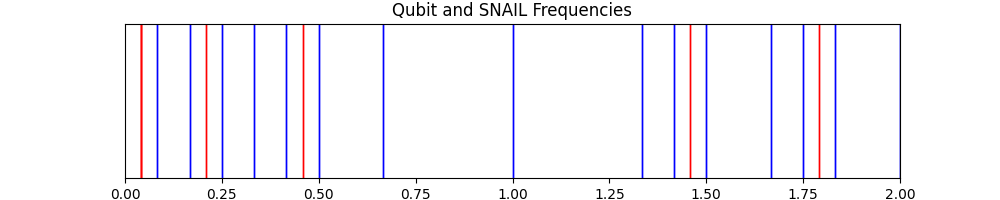

In [20]:
# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 2))

best_frequencies = fixed_frequencies + [snail_freq]
num_qubits = len(best_frequencies) - 1

frequency_dict = {}
for qubit in range(num_qubits):
    frequency_dict[f"qubit_{qubit}"] = ax.axvline(
        best_frequencies[qubit], color="green", linestyle="-", linewidth=3
    )
frequency_dict["snail"] = ax.axvline(
    snail_freq, color="red", linestyle="-", linewidth=2
)


# add frequency pairs to the dictionary (sum and difference)
# use frozenset() to ensure that the order of the keys doesn't matter
for i, mode1 in enumerate(best_frequencies):
    for j, mode2 in enumerate(best_frequencies):
        if i == j:
            continue
        key1 = f"qubit_{i}"
        key2 = f"qubit_{j}"
        if i == len(best_frequencies) - 1:
            key1 = "snail"
        if j == len(best_frequencies) - 1:
            key2 = "snail"

        freq1 = best_frequencies[i]
        freq2 = best_frequencies[j]

        sum_freq = freq1 + freq2
        diff_freq = abs(freq1 - freq2)
        sum_key = f"sum_{key1}_{key2}"
        diff_key = f"diff_{key1}_{key2}"

        alpha = 1
        if "snail" in sum_key:
            color = "red"
            # transparenet
            # alpha = 0
        else:
            color = "blue"

        frequency_dict[sum_key] = ax.axvline(
            sum_freq, color=color, linestyle="-", linewidth=1, alpha=alpha
        )
        frequency_dict[diff_key] = ax.axvline(
            diff_freq, color=color, linestyle="-", linewidth=1, alpha=alpha
        )


# Initialize plot properties
ax.set_xlim(0, 2)
ax.get_yaxis().set_visible(False)
plt.title("Qubit and SNAIL Frequencies")
plt.show()

In [12]:
# Initialize lists to store results for plotting
min_seps = []
avg_seps = []
Ns = list(range(1, 8))  # For example, from 3 to 7 qubits

for N in Ns:
    # Reset initial frequencies for each N
    fixed_frequencies = [min_freq, max_freq]
    for n in range(3, N + 1):
        best_solutions = optimize_additional_qubit(fixed_frequencies)
        if best_solutions:
            fixed_frequencies, _, _ = (
                best_solutions[0][0],
                best_solutions[0][1],
                best_solutions[0][2],
            )

    # After adding all qubits, optimize and add the SNAIL
    snail_freq, min_sep, avg_sep = optimize_snail(fixed_frequencies)

    # Store the final min and avg separations
    min_seps.append(min_sep)
    avg_seps.append(avg_sep)

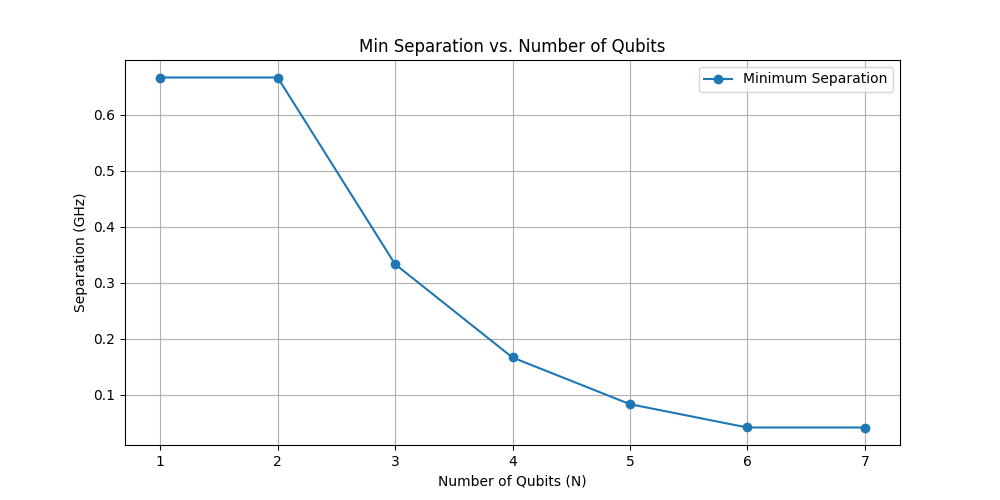

In [13]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(Ns, min_seps, label="Minimum Separation", marker="o")
# plt.plot(Ns, avg_seps, label="Average Separation", marker="x")
plt.xlabel("Number of Qubits (N)")
plt.ylabel("Separation (GHz)")
# plt.title("Min and Avg Separation vs. Number of Qubits")
plt.title("Min Separation vs. Number of Qubits")
plt.legend()
plt.grid(True)
plt.show()